<a href="https://colab.research.google.com/github/renzasprec/CaliforniaHouses/blob/main/CaliforniaHousingHypertuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [129]:
# import helpers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tempfile
from pathlib import Path
import joblib

In [130]:
# import modules from sklearn
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import MinMaxScaler

In [131]:
# import libraries and modules from torch
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import TensorDataset, random_split, DataLoader
import torch.optim as optim

In [132]:
# install and import ray for hyperparameter tuning
try:
    import ray
except ImportError:
    !pip install ray
    import ray

from ray import tune
from ray import train
from ray.train import Checkpoint, get_checkpoint
from ray.tune.schedulers import ASHAScheduler

# Data Preparation and Loading

Load data from fetch_california_housing function

In [133]:
features,target = fetch_california_housing(data_home='/california_housing', as_frame=True, return_X_y=True)

In [134]:
features.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [135]:
features.shape

(20640, 8)

## Data Information

In [136]:
pd.concat([features,target], axis=1).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


## Data Description

In [137]:
pd.concat([features,target], axis=1).describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MedInc,20640.0,3.870671,1.899822,0.499900,2.563400,3.534800,4.743250,15.000100
HouseAge,20640.0,28.639486,12.585558,1.000000,18.000000,29.000000,37.000000,52.000000
AveRooms,20640.0,5.429000,2.474173,0.846154,4.440716,5.229129,6.052381,141.909091
AveBedrms,20640.0,1.096675,0.473911,0.333333,1.006079,1.048780,1.099526,34.066667
Population,20640.0,1425.476744,1132.462122,3.000000,787.000000,1166.000000,1725.000000,35682.000000
AveOccup,20640.0,3.070655,10.386050,0.692308,2.429741,2.818116,3.282261,1243.333333
Latitude,20640.0,35.631861,2.135952,32.540000,33.930000,34.260000,37.710000,41.950000
Longitude,20640.0,-119.569704,2.003532,-124.350000,-121.800000,-118.490000,-118.010000,-114.310000
MedHouseVal,20640.0,2.068558,1.153956,0.149990,1.196000,1.797000,2.647250,5.000010


## Data Loading as Tensors

Selecte device

In [138]:
# check if cuda is available
if torch.cuda.is_available():
  device = torch.device('cuda') # use the GPU
else:
  device = torch.device('cpu') # use the CPU

print(f'current device: {device}')

current device: cpu


In [139]:
def load_data():
  # fetch california housing dataset
  features,targets = fetch_california_housing(data_home='/california_housing', as_frame=True, return_X_y=True)

  # create feature and target tensor
  feature_tensor = torch.tensor(features.values, dtype=torch.float32, device=device)
  target_tensor = torch.tensor(targets.values, dtype=torch.float32, device=device)

  # create dataset tensor
  dataset = TensorDataset(feature_tensor, target_tensor)

  # dataset size
  dataset_size = len(dataset)

  # splitter
  train_dataset, validation_dataset, test_dataset = random_split(dataset, lengths=[int(dataset_size*0.7), int(dataset_size*.15),int(dataset_size)-int(dataset_size*0.7)-int(dataset_size*0.15)])

  # create a MinMaxScaler instance
  scaler = MinMaxScaler()

  # fit scaler to training features
  scaler.fit(
      train_dataset.dataset.tensors[0].cpu().detach().numpy() # access the features dataset (indexed 0 from the tuple of tensors) and converts it to NumPy array
      )

  # save fitted scaler for further use
  scaler_filename = './californiahousing_scaler.joblib'
  joblib.dump(scaler, scaler_filename)

  return train_dataset, validation_dataset, test_dataset

Load the train, validation, and test datasets as tensors, and the scaler fitted on the train set

In [140]:
  # load data using load_data function
  train_dataset, validation_dataset, test_dataset = load_data() # load data

Create a function for loading the scaler

In [141]:
# define scaler filename
notebook_dir = os.path.abspath(os.path.dirname("__file__"))
scaler_filename = os.path.join(notebook_dir, './californiahousing_scaler.joblib')

In [142]:
def scaler_func(scaler_filename=scaler_filename):
  # loads a scaler object given a scaler_filename
  scaler = joblib.load(scaler_filename)

  return scaler

# Neural Network Configuration

In [143]:
class RegressionNet(nn.Module):
  def __init__(self, input_size, scaler, l1=64, l2=128, l3=256):
    super().__init__() # inherit from parent
    self.scaler = scaler # MinMaxScaler
    self.fc1 = nn.Linear(input_size,l1) # first fully connected layer with input size of input and output size of 64
    self.fc2 = nn.Linear(l1,l2) # second fully connected layer with input size of 64 and output size of 128
    self.fc3 = nn.Linear(l2,l3)
    self.fc4 = nn.Linear(l3,1) # final fully connected layer with output size of 1 corresponding to the prediction

  def forward(self, x): # forward propagation
    x = torch.tensor(data=self.scaler.transform(x.cpu().detach().numpy()), dtype=torch.float32, device=device) # normalization step
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x) # output layer
    return x

# Train Function

In [144]:
def train_func(model, optimizer, train_loader, epoch):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model.train()

  running_loss = 0 # reset running loss to 0 for each epoch
  train_mse = 0 # reset train_mse to 0 for each epoch
  data_points = 0 # reset data_points to 0 for each epoch
  total_data_points = 0 # reset total_data_points to 0 for each epoch

  # iterate over train batches
  for batch_idx, data in enumerate(train_loader):
    inputs, targets = data
    inputs, targets = inputs.to(device), targets.to(device)

    # set gradients to 0
    optimizer.zero_grad()

    # reshape targets
    targets = targets.view(-1,1)

    # forward
    predictions = model(inputs)

    # define loss function
    criterion = nn.MSELoss()

    # loss
    loss = criterion(predictions, targets)

    # backward
    loss.backward()

    # optimizer
    optimizer.step()

    # monitor number of data points processed
    data_points += len(inputs)
    total_data_points += len(inputs)

    # monitor running_loss
    running_loss += loss.item()*len(inputs) # running loss for all batch data points

    # monitor_train_mse
    train_mse += loss.item()*len(inputs)

    # print statistics
    if batch_idx % 100 == 99: # print every 100 mini-batches
      print(f'[{epoch+1}, {batch_idx+1}] loss: {running_loss/data_points}')
      running_loss = 0 # reset running_loss to 0
      data_points = 0 # reset running_loss to 0
  train_mse /= total_data_points

  return train_mse


# Test Function

In [145]:
def test_func(model, optimizer, test_loader):
  # validation loss
  loss = 0
  data_points = 0
  mse = 0

  model.eval()

  for batch_idx, data in enumerate(test_loader):
    with torch.no_grad():
      # loading data
      inputs, targets = data
      inputs, targets = inputs.to(device), targets.to(device)

      # reshape targets
      targets = targets.view(-1,1)

      # forward
      predictions = model(inputs)

      # define loss function
      criterion = nn.MSELoss()

      # loss
      loss = criterion(predictions, targets)

      # monitor loss
      mse += loss.item() * len(inputs) # loss for all batch data points

      # monitor data_points
      data_points += len(inputs)

  # average mse across all data points
  mse /= data_points

  return mse

# Train Loop

In [146]:
def train_housing(config):

  # dataloader
  train_loader = DataLoader(train_dataset, batch_size = config['batch_size'], shuffle=True, num_workers=2)
  validation_loader = DataLoader(validation_dataset, batch_size = config['batch_size'], shuffle=True, num_workers=2)
  test_loader = DataLoader(test_dataset, batch_size = config['batch_size'], shuffle=True, num_workers=2)

  # load the scaler using scaler_func
  scaler = scaler_func(scaler_filename)

  # create network instance with inputs from config
  model = RegressionNet(input_size=8, scaler=scaler, l1=config['l1'], l2=config['l2'], l3=config['l3'])

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model.to(device)

  # define optimizer
  optimizer = optim.Adam(model.parameters(), lr=config["lr"])

  # training loop

  for epoch in range(0,5):
    train_func(model=model, optimizer=optimizer, train_loader=train_loader, epoch=epoch)
    # use validation dataset for evaluation
    mse = test_func(model=model, optimizer=optimizer, test_loader=validation_loader)

    # train report for each epoch
    train.report({'mse':mse})

    # save checkpoint
    with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
      checkpoint = None
      # saves the model
      torch.save(
          model.state_dict(),
          os.path.join(temp_checkpoint_dir, 'model.pth')
      )
      checkpoint = Checkpoint.from_directory(temp_checkpoint_dir)

      # training report
      train.report({'mse': mse}, checkpoint=checkpoint)

  print("Finished Training")

# Hyperparamater Tuning

In [147]:
# define the search_space
search_space ={
    'l1': tune.choice([2**i for i in range(3,9)]),
    'l2': tune.choice([2**i for i in range(3,9)]),
    'l3': tune.choice([2**i for i in range(3,9)]),
    'lr': tune.loguniform(1e-4,1e-3),
    'batch_size': tune.choice([2**i for i in range(4,7)])
}

# define tuner
tuner = tune.Tuner(
    trainable = train_housing,
    param_space = search_space,
    tune_config = tune.TuneConfig(num_samples=20,mode='min', metric='mse')
)

# fit tuner
results = tuner.fit()


2025-01-15 06:36:50,273	WARNING callback.py:136 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


+----------------------------------------------------------------------+
| Configuration for experiment     train_housing_2025-01-15_06-36-50   |
+----------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator               |
| Scheduler                        FIFOScheduler                       |
| Number of trials                 20                                  |
+----------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_housing_2025-01-15_06-36-50

Trial status: 20 PENDING
Current time: 2025-01-15 06:36:51. Total running time: 1s
Logical resource usage: 0/2 CPUs, 0/0 GPUs
+----------------------------------------------------------------------------------------+
| Trial name                  status       l1     l2     l3            lr     batch_size |
+----------------------------------------------------------------------------------------+
| train_

(train_housing pid=27062) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00001_1_batch_size=64,l1=32,l2=16,l3=32,lr=0.0002_2025-01-15_06-36-50/checkpoint_000000)


(train_housing pid=27062) [2, 200] loss: 1.3072645497322082 [repeated 7x across cluster]


(train_housing pid=27062) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00001_1_batch_size=64,l1=32,l2=16,l3=32,lr=0.0002_2025-01-15_06-36-50/checkpoint_000001)
(train_housing pid=27062) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00001_1_batch_size=64,l1=32,l2=16,l3=32,lr=0.0002_2025-01-15_06-36-50/checkpoint_000002)


(train_housing pid=27061) [1, 900] loss: 0.5418917704373598 [repeated 8x across cluster]


(train_housing pid=27061) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00000_0_batch_size=16,l1=32,l2=256,l3=256,lr=0.0004_2025-01-15_06-36-50/checkpoint_000000)



Trial status: 2 RUNNING | 18 PENDING
Current time: 2025-01-15 06:37:21. Total running time: 31s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: 19cca_00000 with mse=0.52650563892468 and params={'l1': 32, 'l2': 256, 'l3': 256, 'lr': 0.00043617427315480206, 'batch_size': 16}
+-------------------------------------------------------------------------------------------------------------------------------+
| Trial name                  status       l1     l2     l3            lr     batch_size     iter     total time (s)        mse |
+-------------------------------------------------------------------------------------------------------------------------------+
| train_housing_19cca_00000   RUNNING      32    256    256   0.000436174             16        2            17.5438   0.526506 |
| train_housing_19cca_00001   RUNNING      32     16     32   0.000174203             64        8            17.4526   0.890129 |
| train_housing_19cca_00002   PENDING      32     16     1

(train_housing pid=27062) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00001_1_batch_size=64,l1=32,l2=16,l3=32,lr=0.0002_2025-01-15_06-36-50/checkpoint_000004) [repeated 2x across cluster]


(train_housing pid=27061) [2, 500] loss: 0.5136182197928428 [repeated 4x across cluster]

Trial train_housing_19cca_00002 started with configuration:
+----------------------------------------------------+
| Trial train_housing_19cca_00002 config             |
+----------------------------------------------------+
| batch_size                                      32 |
| l1                                              32 |
| l2                                              16 |
| l3                                              16 |
| lr                                         0.00017 |
+----------------------------------------------------+


(train_housing pid=27061) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00000_0_batch_size=16,l1=32,l2=256,l3=256,lr=0.0004_2025-01-15_06-36-50/checkpoint_000001)


(train_housing pid=27061) [3, 100] loss: 0.48858604989945886 [repeated 5x across cluster]
(train_housing pid=27426) [1, 200] loss: 5.583499374389649 [repeated 4x across cluster]


(train_housing pid=27426) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00002_2_batch_size=32,l1=32,l2=16,l3=16,lr=0.0002_2025-01-15_06-36-50/checkpoint_000000)


(train_housing pid=27061) [3, 800] loss: 0.4925384795665741 [repeated 8x across cluster]

Trial status: 2 RUNNING | 1 TERMINATED | 17 PENDING
Current time: 2025-01-15 06:37:51. Total running time: 1min 1s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: 19cca_00000 with mse=0.42994000346854677 and params={'l1': 32, 'l2': 256, 'l3': 256, 'lr': 0.00043617427315480206, 'batch_size': 16}
+---------------------------------------------------------------------------------------------------------------------------------+
| Trial name                  status         l1     l2     l3            lr     batch_size     iter     total time (s)        mse |
+---------------------------------------------------------------------------------------------------------------------------------+
| train_housing_19cca_00000   RUNNING        32    256    256   0.000436174             16        6            49.3119   0.42994  |
| train_housing_19cca_00002   RUNNING        32     16     16   0.000

(train_housing pid=27426) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00002_2_batch_size=32,l1=32,l2=16,l3=16,lr=0.0002_2025-01-15_06-36-50/checkpoint_000001) [repeated 2x across cluster]


(train_housing pid=27061) [4, 100] loss: 0.43011786349117753 [repeated 5x across cluster]
(train_housing pid=27061) [4, 400] loss: 0.47897744782269003 [repeated 7x across cluster]


(train_housing pid=27426) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00002_2_batch_size=32,l1=32,l2=16,l3=16,lr=0.0002_2025-01-15_06-36-50/checkpoint_000002)


(train_housing pid=27061) [4, 900] loss: 0.42649253867566583 [repeated 9x across cluster]


(train_housing pid=27426) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00002_2_batch_size=32,l1=32,l2=16,l3=16,lr=0.0002_2025-01-15_06-36-50/checkpoint_000003)


(train_housing pid=27061) [5, 200] loss: 0.4754515444114804 [repeated 5x across cluster]


(train_housing pid=27426) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00002_2_batch_size=32,l1=32,l2=16,l3=16,lr=0.0002_2025-01-15_06-36-50/checkpoint_000004) [repeated 2x across cluster]



Trial train_housing_19cca_00002 completed after 10 iterations at 2025-01-15 06:38:12. Total running time: 1min 22s
+--------------------------------------------------------------+
| Trial train_housing_19cca_00002 result                       |
+--------------------------------------------------------------+
| checkpoint_dir_name                        checkpoint_000004 |
| time_this_iter_s                                     0.00623 |
| time_total_s                                        38.11291 |
| training_iteration                                        10 |
| mse                                                  0.70983 |
+--------------------------------------------------------------+
(train_housing pid=27426) Finished Training
(train_housing pid=27061) [5, 500] loss: 0.46641052439808844 [repeated 4x across cluster]

Trial status: 1 RUNNING | 2 TERMINATED | 17 PENDING
Current time: 2025-01-15 06:38:21. Total running time: 1min 31s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Cur

(train_housing pid=27061) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00000_0_batch_size=16,l1=32,l2=256,l3=256,lr=0.0004_2025-01-15_06-36-50/checkpoint_000004)


(train_housing pid=27850) [1, 100] loss: 5.507981407642364
(train_housing pid=27850) [1, 200] loss: 3.7156477904319765
(train_housing pid=27850) [1, 300] loss: 1.7228156054019927
(train_housing pid=27850) [1, 400] loss: 1.2759911918640137
(train_housing pid=27850) [1, 500] loss: 1.2436394944787026

Trial train_housing_19cca_00004 started with configuration:
+--------------------------------------------------+
| Trial train_housing_19cca_00004 config           |
+--------------------------------------------------+
| batch_size                                    32 |
| l1                                           128 |
| l2                                           256 |
| l3                                           128 |
| lr                                         0.001 |
+--------------------------------------------------+
(train_housing pid=27850) [1, 600] loss: 1.0886511236429215
(train_housing pid=27850) [1, 700] loss: 1.05352280408144
(train_housing pid=27850) [1, 800] loss: 0.99

(train_housing pid=27850) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00003_3_batch_size=16,l1=128,l2=16,l3=128,lr=0.0001_2025-01-15_06-36-50/checkpoint_000000)


(train_housing pid=27965) [1, 300] loss: 0.553670704215765 [repeated 5x across cluster]


(train_housing pid=27965) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00004_4_batch_size=32,l1=128,l2=256,l3=128,lr=0.0010_2025-01-15_06-36-50/checkpoint_000000)


(train_housing pid=27850) [2, 800] loss: 0.555273685157299 [repeated 8x across cluster]


(train_housing pid=27850) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00003_3_batch_size=16,l1=128,l2=16,l3=128,lr=0.0001_2025-01-15_06-36-50/checkpoint_000001)



Trial status: 3 TERMINATED | 2 RUNNING | 15 PENDING
Current time: 2025-01-15 06:38:51. Total running time: 2min 1s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: 19cca_00000 with mse=0.41051413960158056 and params={'l1': 32, 'l2': 256, 'l3': 256, 'lr': 0.00043617427315480206, 'batch_size': 16}
+---------------------------------------------------------------------------------------------------------------------------------+
| Trial name                  status         l1     l2     l3            lr     batch_size     iter     total time (s)        mse |
+---------------------------------------------------------------------------------------------------------------------------------+
| train_housing_19cca_00003   RUNNING       128     16    128   0.000106556             16        4            28.6103   0.546955 |
| train_housing_19cca_00004   RUNNING       128    256    128   0.000997973             32        2            12.6448   0.464021 |
| train_housing_19cca_0000

(train_housing pid=27965) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00004_4_batch_size=32,l1=128,l2=256,l3=128,lr=0.0010_2025-01-15_06-36-50/checkpoint_000002) [repeated 2x across cluster]


(train_housing pid=27965) [4, 300] loss: 0.43965414151549337 [repeated 7x across cluster]


(train_housing pid=27965) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00004_4_batch_size=32,l1=128,l2=256,l3=128,lr=0.0010_2025-01-15_06-36-50/checkpoint_000003) [repeated 2x across cluster]


(train_housing pid=27850) [4, 700] loss: 0.5404524523764849 [repeated 8x across cluster]
(train_housing pid=27965) [5, 400] loss: 0.4263275226950645 [repeated 5x across cluster]


(train_housing pid=27850) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00003_3_batch_size=16,l1=128,l2=16,l3=128,lr=0.0001_2025-01-15_06-36-50/checkpoint_000003)



Trial train_housing_19cca_00004 completed after 10 iterations at 2025-01-15 06:39:17. Total running time: 2min 27s
+--------------------------------------------------------------+
| Trial train_housing_19cca_00004 result                       |
+--------------------------------------------------------------+
| checkpoint_dir_name                        checkpoint_000004 |
| time_this_iter_s                                     0.01156 |
| time_total_s                                        44.24587 |
| training_iteration                                        10 |
| mse                                                  0.48069 |
+--------------------------------------------------------------+
(train_housing pid=27965) Finished Training


(train_housing pid=27965) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00004_4_batch_size=32,l1=128,l2=256,l3=128,lr=0.0010_2025-01-15_06-36-50/checkpoint_000004)


(train_housing pid=27850) [5, 300] loss: 0.4738954530656338 [repeated 3x across cluster]

Trial status: 4 TERMINATED | 1 RUNNING | 15 PENDING
Current time: 2025-01-15 06:39:21. Total running time: 2min 31s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: 19cca_00000 with mse=0.41051413960158056 and params={'l1': 32, 'l2': 256, 'l3': 256, 'lr': 0.00043617427315480206, 'batch_size': 16}
+---------------------------------------------------------------------------------------------------------------------------------+
| Trial name                  status         l1     l2     l3            lr     batch_size     iter     total time (s)        mse |
+---------------------------------------------------------------------------------------------------------------------------------+
| train_housing_19cca_00003   RUNNING       128     16    128   0.000106556             16        8            54.6031   0.498812 |
| train_housing_19cca_00000   TERMINATED     32    256    256   0.00

(train_housing pid=27850) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00003_3_batch_size=16,l1=128,l2=16,l3=128,lr=0.0001_2025-01-15_06-36-50/checkpoint_000004)


(train_housing pid=28450) [1, 100] loss: 4.864468777179718 [repeated 2x across cluster]


(train_housing pid=28450) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00005_5_batch_size=64,l1=64,l2=8,l3=256,lr=0.0002_2025-01-15_06-36-50/checkpoint_000000)
(train_housing pid=28450) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00005_5_batch_size=64,l1=64,l2=8,l3=256,lr=0.0002_2025-01-15_06-36-50/checkpoint_000001)


(train_housing pid=28450) [3, 100] loss: 1.0876570242643355 [repeated 4x across cluster]

Trial train_housing_19cca_00006 started with configuration:
+----------------------------------------------------+
| Trial train_housing_19cca_00006 config             |
+----------------------------------------------------+
| batch_size                                      16 |
| l1                                             256 |
| l2                                              64 |
| l3                                              64 |
| lr                                         0.00025 |
+----------------------------------------------------+


(train_housing pid=28450) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00005_5_batch_size=64,l1=64,l2=8,l3=256,lr=0.0002_2025-01-15_06-36-50/checkpoint_000002)


(train_housing pid=28450) [4, 200] loss: 0.8550736665725708 [repeated 3x across cluster]


(train_housing pid=28450) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00005_5_batch_size=64,l1=64,l2=8,l3=256,lr=0.0002_2025-01-15_06-36-50/checkpoint_000003)



Trial train_housing_19cca_00005 completed after 10 iterations at 2025-01-15 06:39:51. Total running time: 3min 0s
+--------------------------------------------------------------+
| Trial train_housing_19cca_00005 result                       |
+--------------------------------------------------------------+
| checkpoint_dir_name                        checkpoint_000004 |
| time_this_iter_s                                     0.00528 |
| time_total_s                                        22.94707 |
| training_iteration                                        10 |
| mse                                                  0.63804 |
+--------------------------------------------------------------+
(train_housing pid=28450) Finished Training


(train_housing pid=28450) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00005_5_batch_size=64,l1=64,l2=8,l3=256,lr=0.0002_2025-01-15_06-36-50/checkpoint_000004)



Trial status: 6 TERMINATED | 1 RUNNING | 13 PENDING
Current time: 2025-01-15 06:39:51. Total running time: 3min 1s
Logical resource usage: 1.0/2 CPUs, 0/0 GPUs
Current best trial: 19cca_00000 with mse=0.41051413960158056 and params={'l1': 32, 'l2': 256, 'l3': 256, 'lr': 0.00043617427315480206, 'batch_size': 16}
+---------------------------------------------------------------------------------------------------------------------------------+
| Trial name                  status         l1     l2     l3            lr     batch_size     iter     total time (s)        mse |
+---------------------------------------------------------------------------------------------------------------------------------+
| train_housing_19cca_00006   RUNNING       256     64     64   0.000248831             16                                        |
| train_housing_19cca_00000   TERMINATED     32    256    256   0.000436174             16       10            81.004    0.410514 |
| train_housing_19cca_0000

(train_housing pid=28589) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00006_6_batch_size=16,l1=256,l2=64,l3=64,lr=0.0002_2025-01-15_06-36-50/checkpoint_000000)



Trial train_housing_19cca_00007 started with configuration:
+----------------------------------------------------+
| Trial train_housing_19cca_00007 config             |
+----------------------------------------------------+
| batch_size                                      16 |
| l1                                              32 |
| l2                                               8 |
| l3                                              16 |
| lr                                         0.00044 |
+----------------------------------------------------+
(train_housing pid=28589) [2, 200] loss: 0.5635708393156529 [repeated 2x across cluster]
(train_housing pid=28589) [2, 700] loss: 0.4844223827123642 [repeated 8x across cluster]


(train_housing pid=28589) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00006_6_batch_size=16,l1=256,l2=64,l3=64,lr=0.0002_2025-01-15_06-36-50/checkpoint_000001)


(train_housing pid=28838) [1, 800] loss: 1.0674838572740555 [repeated 7x across cluster]


(train_housing pid=28838) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00007_7_batch_size=16,l1=32,l2=8,l3=16,lr=0.0004_2025-01-15_06-36-50/checkpoint_000000)


(train_housing pid=28838) [2, 100] loss: 0.9761020664870739 [repeated 6x across cluster]

Trial status: 6 TERMINATED | 2 RUNNING | 12 PENDING
Current time: 2025-01-15 06:40:21. Total running time: 3min 31s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: 19cca_00000 with mse=0.41051413960158056 and params={'l1': 32, 'l2': 256, 'l3': 256, 'lr': 0.00043617427315480206, 'batch_size': 16}
+---------------------------------------------------------------------------------------------------------------------------------+
| Trial name                  status         l1     l2     l3            lr     batch_size     iter     total time (s)        mse |
+---------------------------------------------------------------------------------------------------------------------------------+
| train_housing_19cca_00006   RUNNING       256     64     64   0.000248831             16        4            32.2392   0.48066  |
| train_housing_19cca_00007   RUNNING        32      8     16   0.00

(train_housing pid=28589) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00006_6_batch_size=16,l1=256,l2=64,l3=64,lr=0.0002_2025-01-15_06-36-50/checkpoint_000002)


(train_housing pid=28838) [3, 100] loss: 0.6113950480520726 [repeated 5x across cluster]
(train_housing pid=28589) [4, 600] loss: 0.47255773164331916 [repeated 7x across cluster]


(train_housing pid=28589) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00006_6_batch_size=16,l1=256,l2=64,l3=64,lr=0.0002_2025-01-15_06-36-50/checkpoint_000003) [repeated 2x across cluster]


(train_housing pid=28589) [5, 100] loss: 0.4553768830001354 [repeated 9x across cluster]
(train_housing pid=28589) [5, 500] loss: 0.49183691799640655 [repeated 8x across cluster]
Trial status: 6 TERMINATED | 2 RUNNING | 12 PENDING
Current time: 2025-01-15 06:40:51. Total running time: 4min 1s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: 19cca_00000 with mse=0.41051413960158056 and params={'l1': 32, 'l2': 256, 'l3': 256, 'lr': 0.00043617427315480206, 'batch_size': 16}
+---------------------------------------------------------------------------------------------------------------------------------+
| Trial name                  status         l1     l2     l3            lr     batch_size     iter     total time (s)        mse |
+---------------------------------------------------------------------------------------------------------------------------------+
| train_housing_19cca_00006   RUNNING       256     64     64   0.000248831             16        8            5

(train_housing pid=28838) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00007_7_batch_size=16,l1=32,l2=8,l3=16,lr=0.0004_2025-01-15_06-36-50/checkpoint_000003) [repeated 2x across cluster]



Trial train_housing_19cca_00006 completed after 10 iterations at 2025-01-15 06:40:54. Total running time: 4min 4s
+--------------------------------------------------------------+
| Trial train_housing_19cca_00006 result                       |
+--------------------------------------------------------------+
| checkpoint_dir_name                        checkpoint_000004 |
| time_this_iter_s                                     0.00465 |
| time_total_s                                        73.43484 |
| training_iteration                                        10 |
| mse                                                  0.43051 |
+--------------------------------------------------------------+
(train_housing pid=28589) Finished Training
(train_housing pid=28838) [5, 500] loss: 0.5333690315485 [repeated 5x across cluster]
(train_housing pid=28838) [5, 900] loss: 0.5686232766509056 [repeated 4x across cluster]

Trial train_housing_19cca_00007 completed after 10 iterations at 2025-01-15 06:4

(train_housing pid=28838) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00007_7_batch_size=16,l1=32,l2=8,l3=16,lr=0.0004_2025-01-15_06-36-50/checkpoint_000004) [repeated 2x across cluster]


(train_housing pid=29345) [1, 100] loss: 2.824853705763817
(train_housing pid=29345) [1, 200] loss: 1.0747960823774338


(train_housing pid=29345) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00008_8_batch_size=64,l1=256,l2=8,l3=128,lr=0.0005_2025-01-15_06-36-50/checkpoint_000000)


(train_housing pid=29345) [2, 100] loss: 0.6973529326915741
(train_housing pid=29345) [2, 200] loss: 0.606024622619152

Trial train_housing_19cca_00009 started with configuration:
+----------------------------------------------------+
| Trial train_housing_19cca_00009 config             |
+----------------------------------------------------+
| batch_size                                      64 |
| l1                                             256 |
| l2                                             256 |
| l3                                              32 |
| lr                                         0.00017 |
+----------------------------------------------------+


(train_housing pid=29345) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00008_8_batch_size=64,l1=256,l2=8,l3=128,lr=0.0005_2025-01-15_06-36-50/checkpoint_000001)


(train_housing pid=29345) [3, 100] loss: 0.5538397762179375
(train_housing pid=29345) [3, 200] loss: 0.5407907193899155

Trial status: 8 TERMINATED | 2 RUNNING | 10 PENDING
Current time: 2025-01-15 06:41:22. Total running time: 4min 31s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: 19cca_00000 with mse=0.41051413960158056 and params={'l1': 32, 'l2': 256, 'l3': 256, 'lr': 0.00043617427315480206, 'batch_size': 16}
+---------------------------------------------------------------------------------------------------------------------------------+
| Trial name                  status         l1     l2     l3            lr     batch_size     iter     total time (s)        mse |
+---------------------------------------------------------------------------------------------------------------------------------+
| train_housing_19cca_00008   RUNNING       256      8    128   0.000483836             64        4            10.8786   0.532263 |
| train_housing_19cca_00009   RUNNING

(train_housing pid=29345) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00008_8_batch_size=64,l1=256,l2=8,l3=128,lr=0.0005_2025-01-15_06-36-50/checkpoint_000002)
(train_housing pid=29345) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00008_8_batch_size=64,l1=256,l2=8,l3=128,lr=0.0005_2025-01-15_06-36-50/checkpoint_000003)


(train_housing pid=29345) [5, 100] loss: 0.5063288766145706 [repeated 5x across cluster]

Trial train_housing_19cca_00008 completed after 10 iterations at 2025-01-15 06:41:28. Total running time: 4min 38s
+--------------------------------------------------------------+
| Trial train_housing_19cca_00008 result                       |
+--------------------------------------------------------------+
| checkpoint_dir_name                        checkpoint_000004 |
| time_this_iter_s                                     0.00491 |
| time_total_s                                        22.26878 |
| training_iteration                                        10 |
| mse                                                  0.46905 |
+--------------------------------------------------------------+
(train_housing pid=29345) Finished Training
(train_housing pid=29469) [3, 100] loss: 0.5980340990424157 [repeated 4x across cluster]


(train_housing pid=29469) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00009_9_batch_size=64,l1=256,l2=256,l3=32,lr=0.0002_2025-01-15_06-36-50/checkpoint_000002) [repeated 4x across cluster]


(train_housing pid=29469) [4, 100] loss: 0.5409074941277504 [repeated 2x across cluster]

Trial train_housing_19cca_00010 started with configuration:
+----------------------------------------------------+
| Trial train_housing_19cca_00010 config             |
+----------------------------------------------------+
| batch_size                                      32 |
| l1                                             128 |
| l2                                              32 |
| l3                                              32 |
| lr                                         0.00037 |
+----------------------------------------------------+

Trial train_housing_19cca_00009 completed after 10 iterations at 2025-01-15 06:41:44. Total running time: 4min 54s
+--------------------------------------------------------------+
| Trial train_housing_19cca_00009 result                       |
+--------------------------------------------------------------+
| checkpoint_dir_name                       

(train_housing pid=29469) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00009_9_batch_size=64,l1=256,l2=256,l3=32,lr=0.0002_2025-01-15_06-36-50/checkpoint_000004) [repeated 2x across cluster]


(train_housing pid=29778) [1, 400] loss: 0.7374819713830948 [repeated 4x across cluster]

Trial status: 10 TERMINATED | 1 RUNNING | 9 PENDING
Current time: 2025-01-15 06:41:52. Total running time: 5min 1s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: 19cca_00000 with mse=0.41051413960158056 and params={'l1': 32, 'l2': 256, 'l3': 256, 'lr': 0.00043617427315480206, 'batch_size': 16}
+---------------------------------------------------------------------------------------------------------------------------------+
| Trial name                  status         l1     l2     l3            lr     batch_size     iter     total time (s)        mse |
+---------------------------------------------------------------------------------------------------------------------------------+
| train_housing_19cca_00010   RUNNING       128     32     32   0.000368354             32                                        |
| train_housing_19cca_00000   TERMINATED     32    256    256   0.000

(train_housing pid=29778) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00010_10_batch_size=32,l1=128,l2=32,l3=32,lr=0.0004_2025-01-15_06-36-51/checkpoint_000000)


(train_housing pid=29778) [2, 300] loss: 0.537588709294796 [repeated 3x across cluster]

Trial train_housing_19cca_00011 started with configuration:
+----------------------------------------------------+
| Trial train_housing_19cca_00011 config             |
+----------------------------------------------------+
| batch_size                                      32 |
| l1                                             256 |
| l2                                              16 |
| l3                                             128 |
| lr                                         0.00064 |
+----------------------------------------------------+


(train_housing pid=29778) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00010_10_batch_size=32,l1=128,l2=32,l3=32,lr=0.0004_2025-01-15_06-36-51/checkpoint_000001)


(train_housing pid=29778) [3, 300] loss: 0.5548232236504554 [repeated 5x across cluster]


(train_housing pid=29778) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00010_10_batch_size=32,l1=128,l2=32,l3=32,lr=0.0004_2025-01-15_06-36-51/checkpoint_000002)
(train_housing pid=29969) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00011_11_batch_size=32,l1=256,l2=16,l3=128,lr=0.0006_2025-01-15_06-36-51/checkpoint_000000)


(train_housing pid=29778) [4, 200] loss: 0.5383782079815864 [repeated 6x across cluster]


(train_housing pid=29778) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00010_10_batch_size=32,l1=128,l2=32,l3=32,lr=0.0004_2025-01-15_06-36-51/checkpoint_000003)
(train_housing pid=29969) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00011_11_batch_size=32,l1=256,l2=16,l3=128,lr=0.0006_2025-01-15_06-36-51/checkpoint_000001)


(train_housing pid=29778) [5, 200] loss: 0.49565575897693637 [repeated 8x across cluster]

Trial train_housing_19cca_00010 completed after 10 iterations at 2025-01-15 06:42:17. Total running time: 5min 27s
+--------------------------------------------------------------+
| Trial train_housing_19cca_00010 result                       |
+--------------------------------------------------------------+
| checkpoint_dir_name                        checkpoint_000004 |
| time_this_iter_s                                     0.00923 |
| time_total_s                                        36.32198 |
| training_iteration                                        10 |
| mse                                                  0.46346 |
+--------------------------------------------------------------+
(train_housing pid=29778) Finished Training


(train_housing pid=29969) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00011_11_batch_size=32,l1=256,l2=16,l3=128,lr=0.0006_2025-01-15_06-36-51/checkpoint_000002) [repeated 2x across cluster]



Trial status: 11 TERMINATED | 1 RUNNING | 8 PENDING
Current time: 2025-01-15 06:42:22. Total running time: 5min 31s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: 19cca_00000 with mse=0.41051413960158056 and params={'l1': 32, 'l2': 256, 'l3': 256, 'lr': 0.00043617427315480206, 'batch_size': 16}
+---------------------------------------------------------------------------------------------------------------------------------+
| Trial name                  status         l1     l2     l3            lr     batch_size     iter     total time (s)        mse |
+---------------------------------------------------------------------------------------------------------------------------------+
| train_housing_19cca_00011   RUNNING       256     16    128   0.00064105              32        6            23.4086   0.461275 |
| train_housing_19cca_00000   TERMINATED     32    256    256   0.000436174             16       10            81.004    0.410514 |
| train_housing_19cca_000

(train_housing pid=29969) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00011_11_batch_size=32,l1=256,l2=16,l3=128,lr=0.0006_2025-01-15_06-36-51/checkpoint_000003)


(train_housing pid=29969) [5, 100] loss: 0.44716423511505127 [repeated 4x across cluster]

Trial train_housing_19cca_00012 started with configuration:
+----------------------------------------------------+
| Trial train_housing_19cca_00012 config             |
+----------------------------------------------------+
| batch_size                                      32 |
| l1                                              16 |
| l2                                               8 |
| l3                                              16 |
| lr                                         0.00073 |
+----------------------------------------------------+

Trial train_housing_19cca_00011 completed after 10 iterations at 2025-01-15 06:42:33. Total running time: 5min 43s
+--------------------------------------------------------------+
| Trial train_housing_19cca_00011 result                       |
+--------------------------------------------------------------+
| checkpoint_dir_name                      

(train_housing pid=29969) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00011_11_batch_size=32,l1=256,l2=16,l3=128,lr=0.0006_2025-01-15_06-36-51/checkpoint_000004)


(train_housing pid=30333) [1, 200] loss: 1.98828950881958 [repeated 5x across cluster]
(train_housing pid=30333) [1, 400] loss: 1.1934983932971954 [repeated 2x across cluster]


(train_housing pid=30333) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00012_12_batch_size=32,l1=16,l2=8,l3=16,lr=0.0007_2025-01-15_06-36-51/checkpoint_000000)



Trial train_housing_19cca_00013 started with configuration:
+----------------------------------------------------+
| Trial train_housing_19cca_00013 config             |
+----------------------------------------------------+
| batch_size                                      16 |
| l1                                              64 |
| l2                                             256 |
| l3                                               8 |
| lr                                         0.00018 |
+----------------------------------------------------+
(train_housing pid=30333) [2, 400] loss: 0.7170225867629051 [repeated 4x across cluster]


(train_housing pid=30333) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00012_12_batch_size=32,l1=16,l2=8,l3=16,lr=0.0007_2025-01-15_06-36-51/checkpoint_000001)


(train_housing pid=30500) [1, 300] loss: 1.313706881403923 [repeated 6x across cluster]

Trial status: 12 TERMINATED | 2 RUNNING | 6 PENDING
Current time: 2025-01-15 06:42:52. Total running time: 6min 2s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: 19cca_00000 with mse=0.41051413960158056 and params={'l1': 32, 'l2': 256, 'l3': 256, 'lr': 0.00043617427315480206, 'batch_size': 16}
+---------------------------------------------------------------------------------------------------------------------------------+
| Trial name                  status         l1     l2     l3            lr     batch_size     iter     total time (s)        mse |
+---------------------------------------------------------------------------------------------------------------------------------+
| train_housing_19cca_00012   RUNNING        16      8     16   0.000734409             32        4            17.3891   0.586546 |
| train_housing_19cca_00013   RUNNING        64    256      8   0.0001

(train_housing pid=30333) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00012_12_batch_size=32,l1=16,l2=8,l3=16,lr=0.0007_2025-01-15_06-36-51/checkpoint_000002)


(train_housing pid=30500) [1, 600] loss: 1.1490925151109694 [repeated 5x across cluster]


(train_housing pid=30333) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00012_12_batch_size=32,l1=16,l2=8,l3=16,lr=0.0007_2025-01-15_06-36-51/checkpoint_000003)


(train_housing pid=30333) [5, 200] loss: 0.546441655009985 [repeated 8x across cluster]

Trial train_housing_19cca_00012 completed after 10 iterations at 2025-01-15 06:43:05. Total running time: 6min 15s
+--------------------------------------------------------------+
| Trial train_housing_19cca_00012 result                       |
+--------------------------------------------------------------+
| checkpoint_dir_name                        checkpoint_000004 |
| time_this_iter_s                                     0.00946 |
| time_total_s                                        35.58863 |
| training_iteration                                        10 |
| mse                                                  0.52281 |
+--------------------------------------------------------------+
(train_housing pid=30333) Finished Training


(train_housing pid=30333) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00012_12_batch_size=32,l1=16,l2=8,l3=16,lr=0.0007_2025-01-15_06-36-51/checkpoint_000004) [repeated 2x across cluster]


(train_housing pid=30500) [2, 600] loss: 0.5569499468803406 [repeated 8x across cluster]
(train_housing pid=30500) [2, 800] loss: 0.5076701699197292 [repeated 2x across cluster]


(train_housing pid=30500) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00013_13_batch_size=16,l1=64,l2=256,l3=8,lr=0.0002_2025-01-15_06-36-51/checkpoint_000001)



Trial train_housing_19cca_00014 started with configuration:
+----------------------------------------------------+
| Trial train_housing_19cca_00014 config             |
+----------------------------------------------------+
| batch_size                                      64 |
| l1                                              16 |
| l2                                              32 |
| l3                                               8 |
| lr                                         0.00027 |
+----------------------------------------------------+
(train_housing pid=30500) [3, 300] loss: 0.5263418456912041 [repeated 4x across cluster]

Trial status: 13 TERMINATED | 2 RUNNING | 5 PENDING
Current time: 2025-01-15 06:43:22. Total running time: 6min 32s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: 19cca_00000 with mse=0.41051413960158056 and params={'l1': 32, 'l2': 256, 'l3': 256, 'lr': 0.00043617427315480206, 'batch_size': 16}
+---------------------------------------

(train_housing pid=30824) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00014_14_batch_size=64,l1=16,l2=32,l3=8,lr=0.0003_2025-01-15_06-36-51/checkpoint_000000)


(train_housing pid=30500) [4, 100] loss: 0.5975530780851841 [repeated 4x across cluster]


(train_housing pid=30824) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00014_14_batch_size=64,l1=16,l2=32,l3=8,lr=0.0003_2025-01-15_06-36-51/checkpoint_000002) [repeated 3x across cluster]


(train_housing pid=30500) [4, 600] loss: 0.49952441699802874 [repeated 9x across cluster]

Trial train_housing_19cca_00014 completed after 10 iterations at 2025-01-15 06:43:38. Total running time: 6min 48s
+--------------------------------------------------------------+
| Trial train_housing_19cca_00014 result                       |
+--------------------------------------------------------------+
| checkpoint_dir_name                        checkpoint_000004 |
| time_this_iter_s                                     0.00678 |
| time_total_s                                        20.45662 |
| training_iteration                                        10 |
| mse                                                  0.75838 |
+--------------------------------------------------------------+
(train_housing pid=30824) Finished Training


(train_housing pid=30824) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00014_14_batch_size=64,l1=16,l2=32,l3=8,lr=0.0003_2025-01-15_06-36-51/checkpoint_000004) [repeated 2x across cluster]
(train_housing pid=30500) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00013_13_batch_size=16,l1=64,l2=256,l3=8,lr=0.0002_2025-01-15_06-36-51/checkpoint_000003)


(train_housing pid=30500) [5, 100] loss: 0.5131307468563319 [repeated 6x across cluster]

Trial train_housing_19cca_00015 started with configuration:
+----------------------------------------------------+
| Trial train_housing_19cca_00015 config             |
+----------------------------------------------------+
| batch_size                                      32 |
| l1                                              16 |
| l2                                             128 |
| l3                                              16 |
| lr                                         0.00024 |
+----------------------------------------------------+
(train_housing pid=30500) [5, 700] loss: 0.4582758989185095 [repeated 6x across cluster]

Trial status: 14 TERMINATED | 2 RUNNING | 4 PENDING
Current time: 2025-01-15 06:43:52. Total running time: 7min 2s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: 19cca_00000 with mse=0.41051413960158056 and params={'l1': 32, 'l2': 256, 'l3': 256, 

(train_housing pid=30500) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00013_13_batch_size=16,l1=64,l2=256,l3=8,lr=0.0002_2025-01-15_06-36-51/checkpoint_000004)


(train_housing pid=31172) [1, 300] loss: 1.951649267077446 [repeated 5x across cluster]


(train_housing pid=31172) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00015_15_batch_size=32,l1=16,l2=128,l3=16,lr=0.0002_2025-01-15_06-36-51/checkpoint_000000)


(train_housing pid=31172) [2, 100] loss: 1.1632641220092774 [repeated 2x across cluster]

Trial train_housing_19cca_00016 started with configuration:
+----------------------------------------------------+
| Trial train_housing_19cca_00016 config             |
+----------------------------------------------------+
| batch_size                                      64 |
| l1                                              16 |
| l2                                              32 |
| l3                                              64 |
| lr                                         0.00011 |
+----------------------------------------------------+


(train_housing pid=31172) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00015_15_batch_size=32,l1=16,l2=128,l3=16,lr=0.0002_2025-01-15_06-36-51/checkpoint_000001)


(train_housing pid=31172) [3, 100] loss: 0.9325777593255044 [repeated 4x across cluster]


(train_housing pid=31337) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00016_16_batch_size=64,l1=16,l2=32,l3=64,lr=0.0001_2025-01-15_06-36-51/checkpoint_000000)


(train_housing pid=31337) [2, 100] loss: 3.226222151517868 [repeated 6x across cluster]


(train_housing pid=31172) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00015_15_batch_size=32,l1=16,l2=128,l3=16,lr=0.0002_2025-01-15_06-36-51/checkpoint_000002)
(train_housing pid=31337) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00016_16_batch_size=64,l1=16,l2=32,l3=64,lr=0.0001_2025-01-15_06-36-51/checkpoint_000002) [repeated 2x across cluster]



Trial status: 15 TERMINATED | 2 RUNNING | 3 PENDING
Current time: 2025-01-15 06:44:22. Total running time: 7min 32s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: 19cca_00000 with mse=0.41051413960158056 and params={'l1': 32, 'l2': 256, 'l3': 256, 'lr': 0.00043617427315480206, 'batch_size': 16}
+---------------------------------------------------------------------------------------------------------------------------------+
| Trial name                  status         l1     l2     l3            lr     batch_size     iter     total time (s)        mse |
+---------------------------------------------------------------------------------------------------------------------------------+
| train_housing_19cca_00015   RUNNING        16    128     16   0.000236265             32        6            26.7644   0.61822  |
| train_housing_19cca_00016   RUNNING        16     32     64   0.000112408             64        6            15.2273   1.31366  |
| train_housing_19cca_000

(train_housing pid=31337) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00016_16_batch_size=64,l1=16,l2=32,l3=64,lr=0.0001_2025-01-15_06-36-51/checkpoint_000004) [repeated 3x across cluster]



Trial train_housing_19cca_00015 completed after 10 iterations at 2025-01-15 06:44:29. Total running time: 7min 39s
+--------------------------------------------------------------+
| Trial train_housing_19cca_00015 result                       |
+--------------------------------------------------------------+
| checkpoint_dir_name                        checkpoint_000004 |
| time_this_iter_s                                     0.01075 |
| time_total_s                                        39.35842 |
| training_iteration                                        10 |
| mse                                                  0.51842 |
+--------------------------------------------------------------+

Trial train_housing_19cca_00017 started with configuration:
+----------------------------------------------------+
| Trial train_housing_19cca_00017 config             |
+----------------------------------------------------+
| batch_size                                      64 |
| l1              

(train_housing pid=31764) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00017_17_batch_size=64,l1=16,l2=32,l3=64,lr=0.0005_2025-01-15_06-36-51/checkpoint_000000) [repeated 2x across cluster]


(train_housing pid=31766) [2, 200] loss: 1.1932340216636659 [repeated 6x across cluster]

Trial status: 17 TERMINATED | 2 RUNNING | 1 PENDING
Current time: 2025-01-15 06:44:52. Total running time: 8min 2s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: 19cca_00000 with mse=0.41051413960158056 and params={'l1': 32, 'l2': 256, 'l3': 256, 'lr': 0.00043617427315480206, 'batch_size': 16}
+---------------------------------------------------------------------------------------------------------------------------------+
| Trial name                  status         l1     l2     l3            lr     batch_size     iter     total time (s)        mse |
+---------------------------------------------------------------------------------------------------------------------------------+
| train_housing_19cca_00017   RUNNING        16     32     64   0.000523566             64        4           11.6091    0.640291 |
| train_housing_19cca_00018   RUNNING        16     32    128   0.000

(train_housing pid=31764) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00017_17_batch_size=64,l1=16,l2=32,l3=64,lr=0.0005_2025-01-15_06-36-51/checkpoint_000002) [repeated 4x across cluster]


(train_housing pid=31766) [4, 100] loss: 1.0583375161886215 [repeated 7x across cluster]


(train_housing pid=31766) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00018_18_batch_size=64,l1=16,l2=32,l3=128,lr=0.0001_2025-01-15_06-36-51/checkpoint_000003) [repeated 3x across cluster]



Trial train_housing_19cca_00017 completed after 10 iterations at 2025-01-15 06:45:02. Total running time: 8min 12s
+--------------------------------------------------------------+
| Trial train_housing_19cca_00017 result                       |
+--------------------------------------------------------------+
| checkpoint_dir_name                        checkpoint_000004 |
| time_this_iter_s                                     0.00987 |
| time_total_s                                        22.76191 |
| training_iteration                                        10 |
| mse                                                  0.50665 |
+--------------------------------------------------------------+
(train_housing pid=31764) Finished Training
(train_housing pid=31766) [5, 100] loss: 0.929458886384964 [repeated 4x across cluster]

Trial train_housing_19cca_00018 completed after 10 iterations at 2025-01-15 06:45:06. Total running time: 8min 16s
+--------------------------------------------------

(train_housing pid=31766) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00018_18_batch_size=64,l1=16,l2=32,l3=128,lr=0.0001_2025-01-15_06-36-51/checkpoint_000004) [repeated 2x across cluster]



Trial train_housing_19cca_00019 started with configuration:
+----------------------------------------------------+
| Trial train_housing_19cca_00019 config             |
+----------------------------------------------------+
| batch_size                                      32 |
| l1                                              32 |
| l2                                               8 |
| l3                                               8 |
| lr                                         0.00094 |
+----------------------------------------------------+
(train_housing pid=31766) Finished Training
(train_housing pid=32189) [1, 100] loss: 4.759677908420563 [repeated 2x across cluster]


(train_housing pid=32189) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00019_19_batch_size=32,l1=32,l2=8,l3=8,lr=0.0009_2025-01-15_06-36-51/checkpoint_000000)


(train_housing pid=32189) [2, 200] loss: 0.5618675117194653 [repeated 5x across cluster]


(train_housing pid=32189) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00019_19_batch_size=32,l1=32,l2=8,l3=8,lr=0.0009_2025-01-15_06-36-51/checkpoint_000001)



Trial status: 19 TERMINATED | 1 RUNNING
Current time: 2025-01-15 06:45:22. Total running time: 8min 32s
Logical resource usage: 1.0/2 CPUs, 0/0 GPUs
Current best trial: 19cca_00000 with mse=0.41051413960158056 and params={'l1': 32, 'l2': 256, 'l3': 256, 'lr': 0.00043617427315480206, 'batch_size': 16}
+---------------------------------------------------------------------------------------------------------------------------------+
| Trial name                  status         l1     l2     l3            lr     batch_size     iter     total time (s)        mse |
+---------------------------------------------------------------------------------------------------------------------------------+
| train_housing_19cca_00019   RUNNING        32      8      8   0.000937255             32        4            10.4326   0.519382 |
| train_housing_19cca_00000   TERMINATED     32    256    256   0.000436174             16       10            81.004    0.410514 |
| train_housing_19cca_00001   TERMINA

(train_housing pid=32189) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00019_19_batch_size=32,l1=32,l2=8,l3=8,lr=0.0009_2025-01-15_06-36-51/checkpoint_000002)


(train_housing pid=32189) [4, 100] loss: 0.5153458598256111 [repeated 7x across cluster]


(train_housing pid=32189) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00019_19_batch_size=32,l1=32,l2=8,l3=8,lr=0.0009_2025-01-15_06-36-51/checkpoint_000003)


(train_housing pid=32189) [5, 400] loss: 0.516531143784523 [repeated 7x across cluster]


2025-01-15 06:45:32,430	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/train_housing_2025-01-15_06-36-50' in 0.0248s.



Trial train_housing_19cca_00019 completed after 10 iterations at 2025-01-15 06:45:32. Total running time: 8min 42s
+--------------------------------------------------------------+
| Trial train_housing_19cca_00019 result                       |
+--------------------------------------------------------------+
| checkpoint_dir_name                        checkpoint_000004 |
| time_this_iter_s                                     0.00464 |
| time_total_s                                        21.22974 |
| training_iteration                                        10 |
| mse                                                  0.46953 |
+--------------------------------------------------------------+

Trial status: 20 TERMINATED
Current time: 2025-01-15 06:45:32. Total running time: 8min 42s
Logical resource usage: 1.0/2 CPUs, 0/0 GPUs
Current best trial: 19cca_00000 with mse=0.41051413960158056 and params={'l1': 32, 'l2': 256, 'l3': 256, 'lr': 0.00043617427315480206, 'batch_size': 16}
+-------

(train_housing pid=32189) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_housing_2025-01-15_06-36-50/train_housing_19cca_00019_19_batch_size=32,l1=32,l2=8,l3=8,lr=0.0009_2025-01-15_06-36-51/checkpoint_000004)


# Model Training with Best Configuration

In [148]:
# retrieve best results
best_results = results.get_best_result()
best_config = best_results.config
best_checkpoint = best_results.checkpoint

print(best_config)


{'l1': 32, 'l2': 256, 'l3': 256, 'lr': 0.00043617427315480206, 'batch_size': 16}


Continue training with the best configuration

In [149]:
def train_housing_best(config, best_checkpoint, epoch_start=0, epoch_end=100, patience=5):

  # dataloader
  train_loader = DataLoader(train_dataset, batch_size = config['batch_size'], shuffle=True, num_workers=2)
  validation_loader = DataLoader(validation_dataset, batch_size = config['batch_size'], shuffle=True, num_workers=2)

  # load scaler
  scaler = scaler_func(scaler_filename=scaler_filename)

  # create network instance with inputs from config
  model = RegressionNet(input_size=8, scaler=scaler, l1=config['l1'], l2=config['l2'], l3=config['l3'])

  with best_checkpoint.as_directory() as checkpoint_dir:
    model.load_state_dict(torch.load(os.path.join(checkpoint_dir, 'model.pth')))

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model.to(device)

  # define optimizer
  optimizer = optim.Adam(model.parameters(), lr=config["lr"])

  # training loop

  history = {'epoch':[], 'train_mse':[], 'validation_mse':[]} # dictionary for history of epoch and mse
  best_validation_mse = float('inf') # initialize best validation mse with a large value
  patience = patience # number of epochs to wait for improvement
  counter = 0

  for epoch in range(epoch_start,epoch_end):
    train_mse = train_func(model=model, optimizer=optimizer, train_loader=train_loader, epoch=epoch)
    # use validation for model evaluation
    validation_mse = test_func(model=model, optimizer=optimizer, test_loader=validation_loader)

    history['epoch'].append(epoch)
    history['train_mse'].append(train_mse)
    history['validation_mse'].append(validation_mse)

    # check for improvement
    if validation_mse < best_validation_mse:
      best_validation_mse = validation_mse
      counter = 0 # reset if validation mse improves
    else:
      counter += 1

    # early stopping

    if counter >= patience:
      print(f'Early stopping at epoch {epoch+1}')
      # save model for future use if stopped early
      path = './californiahousing_net.pth'
      torch.save(model.state_dict(), path) # saves the state_dict of the model
      break # exit loop

  print("Finished Training")
  # save model for future use after completion of training
  path = './californiahousing_net.pth'
  torch.save(model.state_dict(), path) # saves the state_dict of the model
  return history

In [150]:
history = train_housing_best(config=best_config, best_checkpoint=best_checkpoint, epoch_start=5, epoch_end=101, patience=8)

<ipython-input-149-742301022a4f>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(checkpoint_dir, 'model.pth')))


[6, 100] loss: 0.43992550946772097
[6, 200] loss: 0.41003829181194307
[6, 300] loss: 0.46025003008544446
[6, 400] loss: 0.4619616287946701
[6, 500] loss: 0.4018963458389044
[6, 600] loss: 0.42284397169947624
[6, 700] loss: 0.3784097822383046
[6, 800] loss: 0.4788512632995844
[6, 900] loss: 0.4361240126937628
[7, 100] loss: 0.4467804666608572
[7, 200] loss: 0.40777265556156633
[7, 300] loss: 0.44675603047013285
[7, 400] loss: 0.42123438805341723
[7, 500] loss: 0.4345101089775562
[7, 600] loss: 0.39720775790512564
[7, 700] loss: 0.43883985668420794
[7, 800] loss: 0.44071739077568056
[7, 900] loss: 0.39165641434490683
[8, 100] loss: 0.44095240227878096
[8, 200] loss: 0.4314886587113142
[8, 300] loss: 0.38980943635106086
[8, 400] loss: 0.39842921018600463
[8, 500] loss: 0.4675421653687954
[8, 600] loss: 0.39858133062720297
[8, 700] loss: 0.44441462561488154
[8, 800] loss: 0.379276030883193
[8, 900] loss: 0.4324522841349244
[9, 100] loss: 0.40792856000363825
[9, 200] loss: 0.410123336315155

## Plotting Metrics

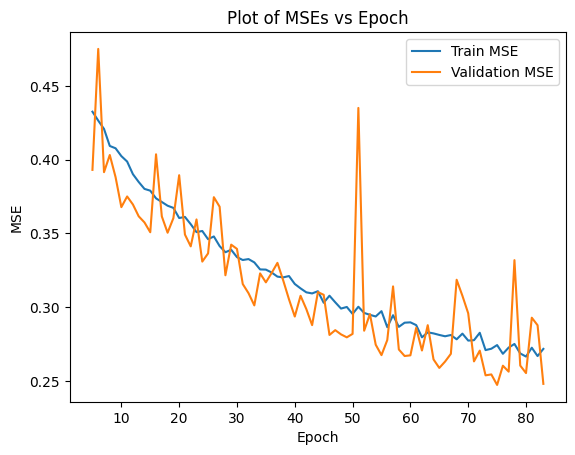

In [151]:
# Plot the MSEs vs epoch
fig, ax1 = plt.subplots()

# plot train_mse vs epoch
ax1.plot(history['epoch'], history['train_mse'], label='Train MSE')

# superimpose validation mse vs epoch
ax1.plot(history['epoch'], history['validation_mse'], label='Validation MSE')

# add legend
ax1.legend();

# title
ax1.set_title('Plot of MSEs vs Epoch')

# labels
ax1.set_xlabel('Epoch')
ax1.set_ylabel('MSE')

# display plot
plt.show()


# Model Evaluation on Test Data

## Loading the Model

In [152]:
# load scaler
scaler = scaler_func(scaler_filename=scaler_filename)

# Define model using the best configuration
model = RegressionNet(input_size=8, scaler=scaler, l1=best_config['l1'], l2=best_config['l2'], l3=best_config['l3'])

# load state_dictionary from a save file
path = './californiahousing_net.pth'

# load model
model.load_state_dict(torch.load(path, weights_only=True))

<All keys matched successfully>

## Evaluation on the Test Data

In [153]:
# load test data
test_loader = DataLoader(test_dataset, batch_size = best_config['batch_size'], shuffle=True, num_workers=2)

model.eval()
with torch.no_grad():
  test_mse = 0 # set initial mse to 0
  data_points = 0
  for data in test_loader:
    inputs, targets = data

    targets = targets.view(-1,1)

    # predictions
    predictions = model(inputs)

    # define loss function
    criterion = nn.MSELoss()

    # loss
    loss = criterion(predictions, targets)

    # monitor number of data points
    data_points += len(inputs)

    # monitor MSE
    test_mse += loss.item()*len(inputs) # right side multiplies the average batch mse to the total number of inputs
  # take the average MSE across the entire dataset
  test_mse /= data_points

  print (f'Test MSE: {test_mse:.4f} \nTest RMSE: {np.sqrt(test_mse):.4f}')


Test MSE: 0.2981 
Test RMSE: 0.5460
